In [1]:
import sys
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import patches

import tqdm

sys.path.append("..")
from util.statdist import log_likelihood
from util.plot import Background, add_panel_letters

%matplotlib inline

In [2]:
dfr = pd.read_pickle("../run/Taa/df-grouped-rec.pkl")
dfm = pd.read_pickle("../run/Taa/df-grouped-sim.pkl")

In [3]:
dfr = dfr.drop(columns=['contacts', 'tfr', 'tto', 'cc', 'freq', 'dist_to_cortex', 'dist_to_szpatch'])
dfm = dfm.drop(columns=['contacts', 'tfr', 'tto', 'cc', 'freq', 'dist_to_cortex', 'dist_to_szpatch'])

In [4]:
variables = ['tdur',         'tfr_slope',       'tfr_r2',   'pca_ve1',  'pca_ve2ac']
noises = [0, 1]
models = ["onestat", "twostat", "propwaves"]
confs = dfr.detconf.unique()

In [5]:
dffm = dfm[(dfm.detconf == 0)].copy()
len(dffm)

207145

In [6]:
dffm['f'] = 0.
dffm['patch_size'] = 0.

for subject, model, noise in tqdm.tqdm(dffm[['subject', 'model', 'noise']].drop_duplicates().values,
                                       position=0, leave=True):
    conf = pd.read_pickle(f"../run/Taa/simulations/configs_{subject}_{model}_{noise}.pkl")
    
    dff = dffm[(dffm.subject == subject) & (dffm.model == model) & (dffm.noise == noise)]
    
    for j, row in conf.iterrows():
        inds = dff.index[dff.rec == j]
        dffm.loc[inds, 'f'] = row.freq
        dffm.loc[inds, 'patch_size'] = row.patch_size

100%|██████████| 450/450 [04:59<00:00,  1.66it/s]


In [7]:
dffm.f.min(), dffm.f.max()

(4.000085351049397, 12.991254168259768)

In [8]:
dffm.patch_size.min(), dffm.patch_size.max()

(400.01025723362346, 2499.9922559345755)

In [10]:
np.random.seed(42)

nbootstrap = 1000

loglik = np.zeros((len(confs) + 4, len(models), len(noises), nbootstrap))

# Different detection configurations
for i, conf in tqdm.tqdm(enumerate(confs), position=0, leave=True, total=len(confs)):
    dff = dfr[dfr.detconf == conf]
    nsamples = len(dff)
    mus = np.array([dff[var].mean() for var in variables])
    stds = np.array([dff[var].std() for var in variables])     
    fr = (dff[variables].values - mus)/stds
    
    inds = np.random.choice(nsamples, size=(nbootstrap, nsamples), replace=True)

    for j, model in enumerate(models):
        for k, noise in enumerate(noises):
            dff = dfm[(dfm.model == model) & (dfm.noise == noise) & (dfm.detconf == conf)]   
            fm = (dff[variables].values - mus)/stds
            for l in range(nbootstrap):
                frres = fr[inds[l], :]
                loglik[i, j, k, l] = log_likelihood(frres, fm, k=10)


# Different model parameters                
dff = dfr[dfr.detconf == 0]
nsamples = len(dff)
mus = np.array([dff[var].mean() for var in variables])
stds = np.array([dff[var].std() for var in variables])                    
fr = (dff[variables].values - mus)/stds

inds = np.random.choice(nsamples, size=(nbootstrap, nsamples), replace=True)

for i, (fmin, fmax, psmin, psmax) in tqdm.tqdm(enumerate([[4, 7, 400, 2500], [7, 13, 400, 2500],
                                                          [4, 13, 400, 1000], [4, 13, 1000, 2500]]),
                                               total=4, position=0, leave=True):

    for j, model in enumerate(models):
        for k, noise in enumerate(noises):
            dff = dffm[((dffm.model == model) & (dffm.noise == noise) &
                        (dffm.f >= fmin) & (dffm.f < fmax) &
                        (dffm.patch_size >= psmin) & (dffm.patch_size < psmax))]
            fm = (dff[variables].values - mus)/stds
            
            for l in range(nbootstrap):        
                frres = fr[inds[l], :]                
                loglik[len(confs) + i, j, k, l] = log_likelihood(frres, fm, k=10)

100%|██████████| 4/4 [10:03<00:00, 151.28s/it]


In [11]:
loglik.shape # confs, models, noise, bootstrap

(17, 3, 2, 1000)

In [12]:
np.save("res/loglik.npy", loglik)

In [13]:
refmodel = 2
refnoise = 1
dloglik = loglik - loglik[:, refmodel, refnoise, :][:, None, None, :]

In [16]:
model_names = ["OS", "TS", "SS"]
noise_names = ["Noise-free", "Noisy"]

def remove_borders(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis=u'y', length=0)
  
def plot_one_ci(ax, x, yticks, iref=None, jref=None, xref=None):
    nmodels, nnoises, _ = x.shape
    ci = np.percentile(x, [2.5, 50.0, 97.5], axis=-1)
    ci = np.moveaxis(ci, [0, 1, 2], [2, 0, 1])
    
    plt.sca(ax)

    labels = []
    ypos = 0
    for i in range(nmodels):
        for j in range(nnoises):
            if i != iref or j != jref:                
                plt.plot(ci[i, j, [0, 2]], [ypos, ypos], 'k-')
                plt.scatter(ci[i, j, 1], ypos, s=20, color='k')
                labels.append(noise_names[j] + " " + model_names[i])
                ypos += 1 
    if yticks:
        plt.yticks(np.r_[:len(labels)], labels)
    else:
        plt.yticks([])
    
    if xref is not None:
        plt.axvline(xref, ls='--', color='0.5', zorder=-1)
    remove_borders(ax)

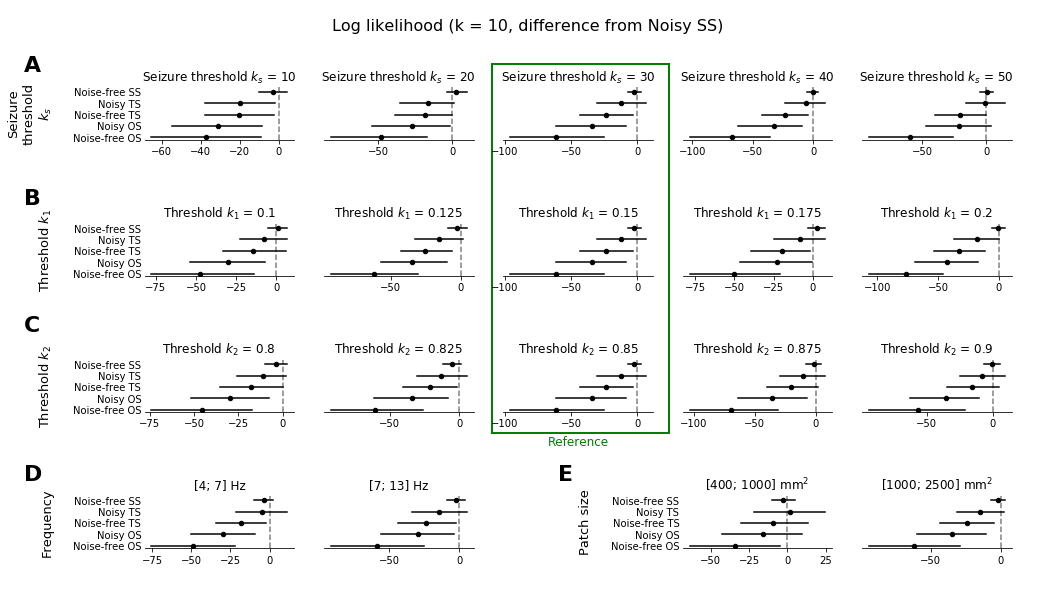

In [17]:
confsets = [[1, 2, 0, 3, 4], [5, 6, 0, 7, 8], [9, 10, 0, 11, 12]]
parameters = ["Seizure threshold $k_s$", "Threshold $k_1$", "Threshold $k_2$"]
values = [[10, 20, 30, 40, 50], [0.100, 0.125, 0.150, 0.175, 0.200], [0.800, 0.825, 0.850, 0.875, 0.900]]

plt.figure(figsize=(14, 8))
gs = GridSpec(4, 5, left=0.12, right=0.98, bottom=0.06, top=0.86, hspace=1.6)
plt.suptitle("Log likelihood (k = 10, difference from Noisy SS)", fontsize=16)

for i, confset in enumerate(confsets):
    for j, conf in enumerate(confset):        
        ax = plt.subplot(gs[i,j])
        plt.title(f"{parameters[i]} = {values[i][j]}")
        plot_one_ci(ax, dloglik[conf], yticks=(j==0), iref=2, jref=1, xref=0.)
        if j == 0:
            label = parameters[i] + "\n"
            if i == 0:
                label = label.replace(" ", "\n")
            plt.ylabel(label, fontsize=13)
        

plot_one_ci(plt.subplot(gs[3, 0]), dloglik[13], yticks=True, iref=2, jref=1, xref=0.)
plt.title("[4; 7] Hz")
plt.ylabel("Frequency\n", fontsize=13)
plot_one_ci(plt.subplot(gs[3, 1]), dloglik[14], yticks=False, iref=2, jref=1, xref=0.)
plt.title("[7; 13] Hz")

plot_one_ci(plt.subplot(gs[3, 3]), dloglik[15], yticks=True, iref=2, jref=1, xref=0.)
plt.title("[400; 1000] mm$^2$")
plt.ylabel("Patch size\n", fontsize=13)
plot_one_ci(plt.subplot(gs[3, 4]), dloglik[16], yticks=False, iref=2, jref=1, xref=0.)
plt.title("[1000; 2500] mm$^2$")

bg = Background(visible=False)
rect = patches.Rectangle((0.465, 0.26), 0.64-0.465, 0.90-0.26, edgecolor='g', facecolor='none', lw=2)
bg.axes.add_patch(rect)
bg.axes.text(0.55, 0.255, "Reference", color='g', ha='center', va='top', fontsize=12)

bg.labels([0.00, 0.00, 0.00, 0.00, 0.53], [0.88, 0.65, 0.43, 0.17, 0.17], fontsize=22)

plt.savefig("figs/detection-stability.pdf")